# Experiment with color filter

See if we can filter out images we do not want in the positive labelled dataset based on color (i.e. images which are not actually of poison ivy plants, but something different, like perhaps a person showing a rash on their arm)

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from typing import List
from collections import Counter

plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

In [102]:
src_path = '../datasets/pilot_resized'
src_metadata = '../datasets/pilot_resized/dataset_metadata.csv'

manual_metadata = 'manually_labelled_image_data.csv'

my_colors = {
    'green': np.array([60, 220, 60]),
    'brown': np.array([99, 85, 73])
}

In [73]:
df_ims = pd.read_csv(src_metadata, index_col=0)
df_ims = df_ims.join(pd.read_csv(manual_metadata, index_col=0))
df_ims.head()

,full_path,rel_path,is_readable,new_full_path,image_dims,new_image_dims,label,keep,did_not_load,has_text,has_human,wrong_colors
name,,,,,,,,,,,,
Blackberries_plant_1.jpg,/home/code/datasets/pilot_raw/negative/Blackbe...,../datasets/pilot_raw/negative/Blackberries_pl...,True,/home/code/datasets/pilot_resized/negative/Bla...,"(1662, 1247)","(399, 300)",0,1,0,0,0,0
Blackberries_plant_10.jpg,/home/code/datasets/pilot_raw/negative/Blackbe...,../datasets/pilot_raw/negative/Blackberries_pl...,True,/home/code/datasets/pilot_resized/negative/Bla...,"(1200, 630)","(571, 300)",0,1,0,0,0,0
Blackberries_plant_2.jpg,/home/code/datasets/pilot_raw/negative/Blackbe...,../datasets/pilot_raw/negative/Blackberries_pl...,True,/home/code/datasets/pilot_resized/negative/Bla...,"(1556, 1234)","(378, 300)",0,1,0,0,0,0
Blackberries_plant_3.jpg,/home/code/datasets/pilot_raw/negative/Blackbe...,../datasets/pilot_raw/negative/Blackberries_pl...,True,/home/code/datasets/pilot_resized/negative/Bla...,"(450, 600)","(300, 400)",0,1,0,0,0,0
Blackberries_plant_4.jpg,/home/code/datasets/pilot_raw/negative/Blackbe...,../datasets/pilot_raw/negative/Blackberries_pl...,True,/home/code/datasets/pilot_resized/negative/Bla...,"(1280, 960)","(400, 300)",0,1,0,0,0,0


## Test different filters

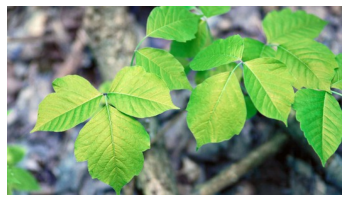

In [47]:
test_im_path = df_ims[df_ims['label'] == 1].iloc[0]['new_full_path']
test_im = cv2.imread(test_im_path)
plt.imshow(test_im)
plt.axis('off')
plt.show()

Metric Functions

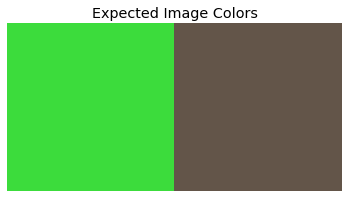

In [194]:
def show_color_samples(colors: List[np.ndarray], n_sq:int = 50, title:str = ""):
    color_disp = np.concatenate([
        np.array([[color_arr for _ in range(n_sq)] for _ in range(n_sq)])
        for color_arr in colors
    ], axis=1)
    plt.imshow(color_disp)
    plt.axis('off')
    plt.title(title)
    plt.show()
    

show_color_samples([*my_colors.values()], n_sq=50, title="Expected Image Colors")

In [181]:
def mean_color(img: np.ndarray) -> np.ndarray:
    """
    Get mean RGB color as (3,) array
    """
    return(np.mean(img, axis=(0,1)))

def mean_green_channel(img: np.ndarray) -> float:
    """
    Get mean of RGB green channel value
    """
    return(np.mean(img, axis=(0,1))[1])

def mean_min_dist_from_colors(img: np.ndarray, colors=List[np.ndarray], ord=2) -> float:
    """
    Get average-minimum distance from a list of colors (get distance from each color, and keep the shortest)
    For example, take smaller distance to either green or brown for each pixel, then average
    """
    return(np.mean(
        np.min(
            np.array([
                np.linalg.norm(img - color, axis=2, ord=ord)
                for color in colors
            ]), axis=0
        )
    ))
    
    
    

def max_color_appearence(img: np.ndarray) -> float:
    """
    Count the fraction of pixels which make up the most common color
    Detects if there is one color appearing too much (i.e. if there is a solid background instead of a more natural looking photo)
    """
    width, height, _ = img.shape
    return(max(Counter(tuple(img[i,j,:])
                       for i in range(width)
                       for j in range(height)).values()) / (height*width))

    
    

# Cluster colors and get distance from (brown, green) (in HSL?)

0.0003377110694183865


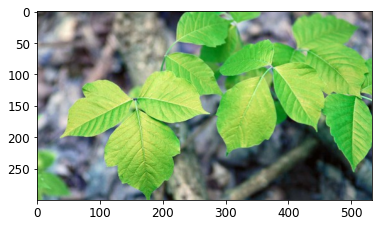

In [154]:
print(max_color_appearence(test_im))
plt.imshow(test_im)


0.489472161966739
78.6672257003558


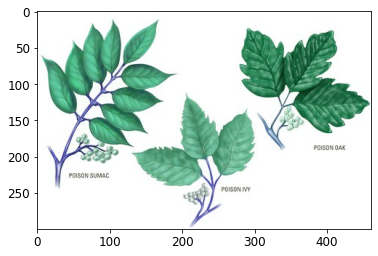

In [182]:
bad_im_name = 'Western_poison_oak_plant_7.jpg'
bad_im_path = df_ims.loc[bad_im_name, 'new_full_path']
bad_im = cv2.imread(bad_im_path)
test_color = [np.array([255,255,255])]
print(max_color_appearence(bad_im))
print(mean_min_dist_from_colors(bad_im, colors=[np.array([255, 255, 255])]))
plt.imshow(bad_im)

In [232]:
# Calculate metrics for potentially separating "bad" images from others
df_ims['mean_green_channel'] = df_ims['new_full_path'].map(lambda im_path: mean_green_channel(cv2.imread(im_path)))
df_ims['mean_dist_from_colors'] = df_ims['new_full_path'].map(
    lambda im_path: mean_min_dist_from_colors(cv2.imread(im_path), colors=[*my_colors.values()]))
df_ims['mean_dist_from_white'] = df_ims['new_full_path'].map(
    lambda im_path: mean_min_dist_from_colors(cv2.imread(im_path), colors=[np.array([255]*3)]))
df_ims['mean_dist_from_white_or_black'] = df_ims['new_full_path'].map(
    lambda im_path: mean_min_dist_from_colors(cv2.imread(im_path), colors=[np.array([255]*3), np.array([0]*3)]))
df_ims['color_appearence_max_frac'] = df_ims['new_full_path'].map(
    lambda im_path: max_color_appearence(cv2.imread(im_path)))

metric_cols = ['mean_green_channel', 'mean_dist_from_colors', 'mean_dist_from_white', 'mean_dist_from_white_or_black', 'color_appearence_max_frac']

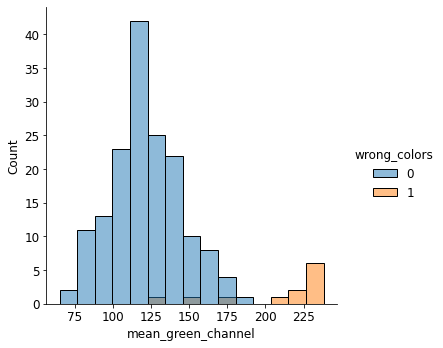

In [233]:
sns.displot(data=df_ims, x='mean_green_channel', hue='wrong_colors')

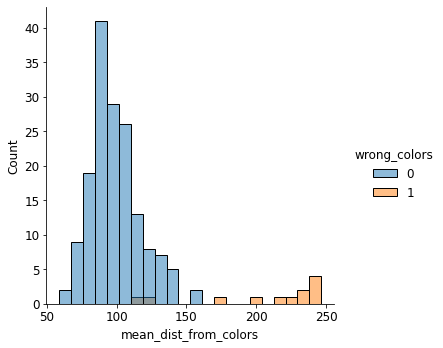

In [234]:
sns.displot(data=df_ims, x='mean_dist_from_colors', hue='wrong_colors')

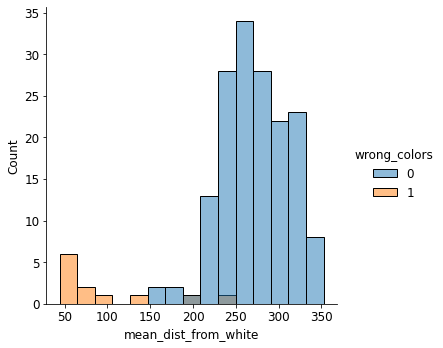

In [235]:
sns.displot(data=df_ims, x='mean_dist_from_white', hue='wrong_colors')

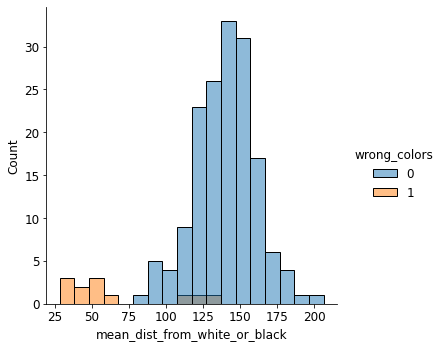

In [236]:
sns.displot(data=df_ims, x='mean_dist_from_white_or_black', hue='wrong_colors')

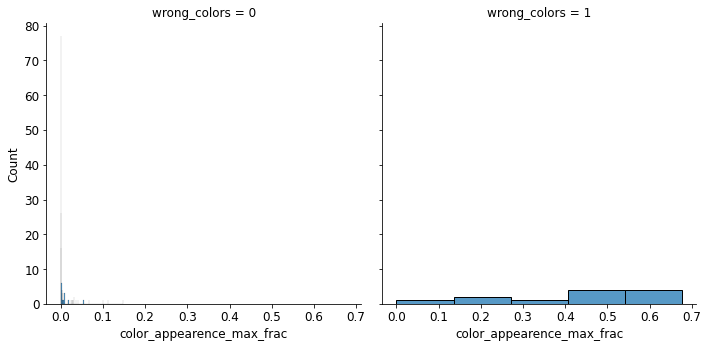

In [237]:
g = sns.FacetGrid(df_ims, col='wrong_colors', height=5)
g.map(sns.histplot, 'color_appearence_max_frac');
# sns.displot(data=df_ims, x='color_appearence_max_frac', hue='wrong_colors')

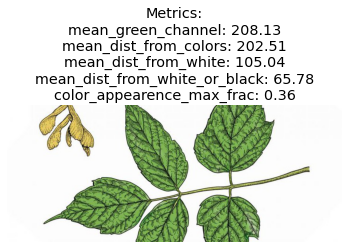

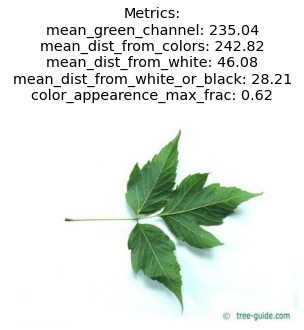

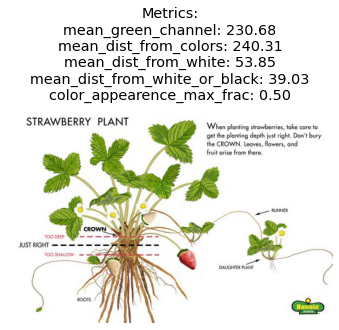

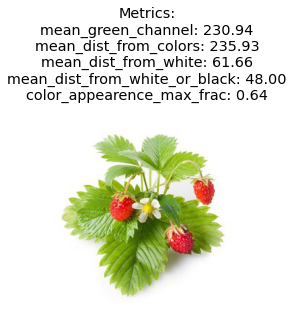

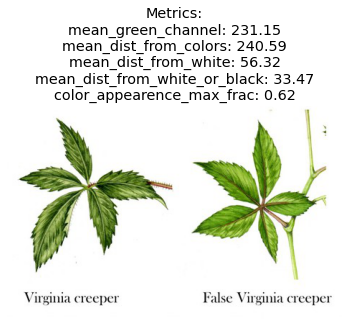

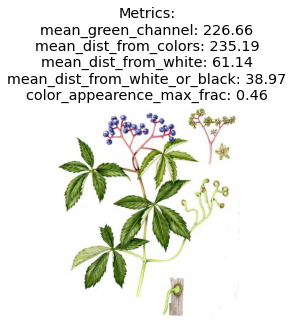

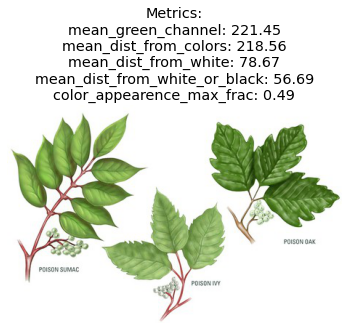

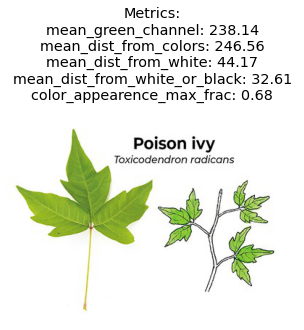

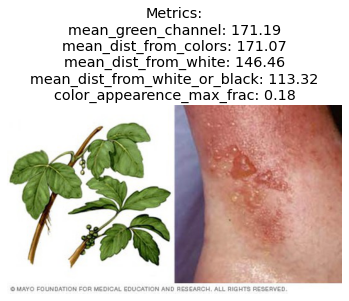

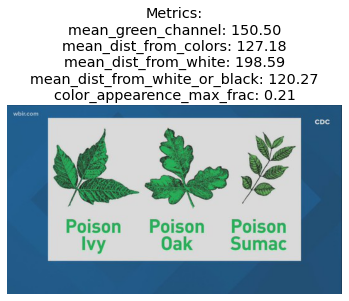

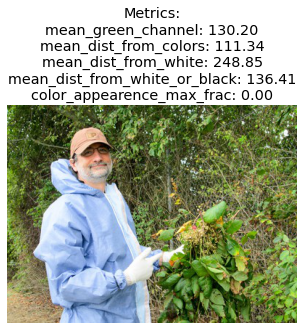

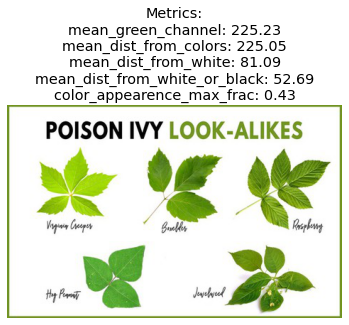

In [239]:
for name, im_row in df_ims[df_ims['wrong_colors'] == 1].iterrows():
    img = Image.open(im_row['new_full_path'])
    
    plt.figure()
    plt.title("Metrics:\n" + "\n".join(f"{metric_val}: {df_ims.loc[name, metric_val]:.2f}" for metric_val in metric_cols))
    plt.axis('off')
    plt.imshow(img)

## Best Result

Best result seems to be counting the pixels. We could not get human detection to work, but it seems counting a solid background & and removing heavy text images will eliminate a lot of the bad images

As a final check, let's look at which images that weren't flagged manually were most likely to get filtered:

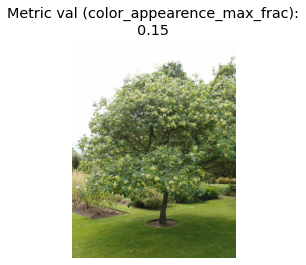

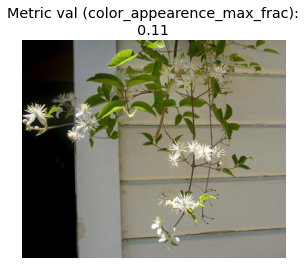

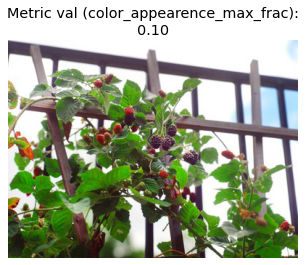

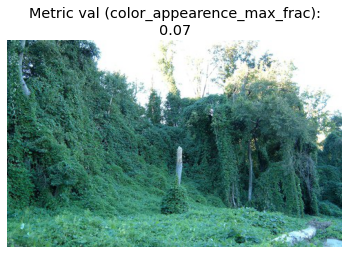

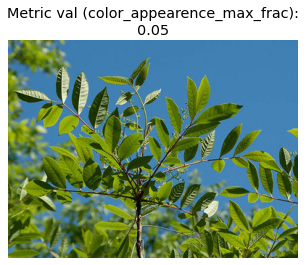

In [242]:
metric_col = 'color_appearence_max_frac'
filter_col = 'wrong_colors'
n_ims = 5

check_ims = [*df_ims[df_ims[filter_col] == 0].sort_values(metric_col, ascending=False).index[:n_ims]]

for name in check_ims:
    img = Image.open(df_ims.at[name, 'new_full_path'])
    plt.figure()
    plt.title(f"Metric val ({metric_col}):\n{df_ims.at[name, metric_col]:.2f}")
    plt.axis('off')
    plt.imshow(img)
    

These images seem to have some natural (i.e. the sky) or unnatural (i.e. house siding) solid background causing them to have high values. It would not be the end of the world to lose a few images to this filter, and therefore we will probably place the filter around 0.1.

## Future results?

Other possible ideas include:
 - Calculating distance in a hue-saturation-brightness space (based on hue) so that we just consider green-ness independently
 - Using a clustering method to determine the "core colors" and making sure those fall in the green-ish or brown-ish range